### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! cp /content/drive/MyDrive/lfw_dataset.py /content/

Mounted at /content/drive


In [ ]:
!ls -a

.  ..  .config	drive  lfw_dataset.py  sample_data


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


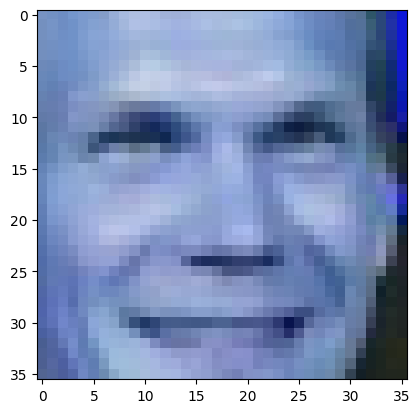

In [ ]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [ ]:
CODE_SIZE = 256

generator = Sequential()
# Transform the input vector into "image-shaped"
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))
generator.add(L.Reshape((8,8,10)))
# Block 1
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
# Block 2
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
# 36x36x32 -> 36x36x3 image
generator.add(L.Conv2D(3,kernel_size=3,activation=None))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 640)               164480    
                                                                 
 reshape (Reshape)           (None, 8, 8, 10)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 12, 12, 64)       16064     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       102464    
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                        

In [ ]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [ ]:
discriminator = Sequential()
# The main idea for the discriminator:
# Simple Disc will represent the pic in lowdim vector with a huge info loss
discriminator.add(L.InputLayer(IMG_SHAPE))
# Block 1
discriminator.add(L.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'))
discriminator.add(L.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'))
discriminator.add(L.MaxPool2D())
# Block 2
discriminator.add(L.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'))
discriminator.add(L.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'))
discriminator.add(L.MaxPool2D())
# Block 3
discriminator.add(L.Conv2D(kernel_size=3, filters=256, padding='same', activation='relu'))
discriminator.add(L.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'))
discriminator.add(L.MaxPool2D(pool_size=3))
discriminator.add(L.GlobalAveragePooling2D())
# Output
discriminator.add(L.Flatten())
discriminator.add(L.Dense(256, activation='tanh'))
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 36, 36, 16)        448       
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                  

# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [ ]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [ ]:
# Adagrad and Adam are the most common used optimizers both for discriminator and generator
# But the discriminator loss while implementing Adam optimizer is more as compared to Adagrad optimizer.
# 0.01 learning rate makes to show good results in 3-5 thousand epochs
# While 0.001 learning rate (default) makes to show good results in few times more epochs
disc_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
gen_optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)

20250
1:26:12.687935
1/1 [==============================] - 0s 17ms/step


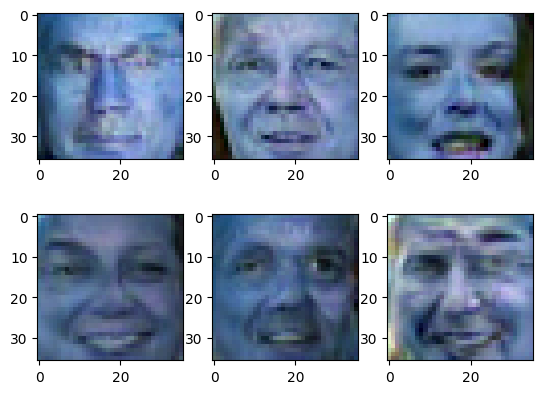

32/32 [==============================] - 0s 3ms/step


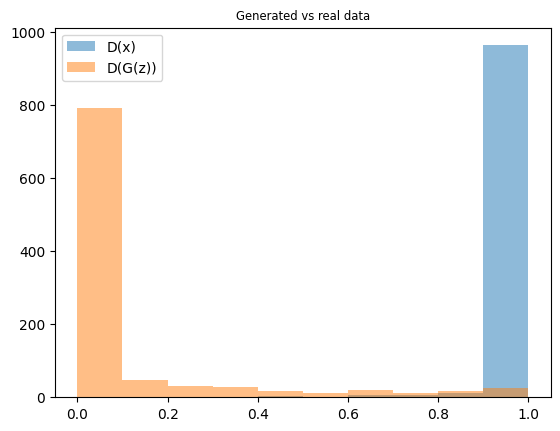

KeyboardInterrupt: ignored

In [ ]:
from IPython import display
from tqdm import tnrange
from time import time
from datetime import timedelta
start = time()

for epoch in tnrange(30000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    # Discriminator training
    # After over 10 tries the best results for the case,
    # When the ratio of training loops is 2:1
    for i in range(2):
        with tf.GradientTape() as tape:
            logp_real = discriminator(real_data)
            generated_data = generator(noise)
            logp_gen = -tf.math.log(1 - discriminator(generated_data))

            # Discriminator improvement
            d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])
            # Regularization
            d_loss += tf.reduce_mean(discriminator.layers[-1].kernel ** 2)

        gradients = tape.gradient(d_loss, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))


    with tf.GradientTape() as tape:
        # Generator improvement
        g_loss = tf.reduce_mean(tf.math.log(1 - discriminator(generator(noise)))[:, 1])

    gradients = tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))


    if epoch % 50 == 0:
        display.clear_output(wait=True)
        print(epoch)
        print(timedelta(seconds=time() - start))
        if epoch % 100 == 0:
            discriminator.save_weights('./discriminator.hdf5')
            generator.save_weights('./generator.hdf5')
        sample_images(2,3,True)
        sample_probas(1000)

4/4 [==============================] - 0s 4ms/step


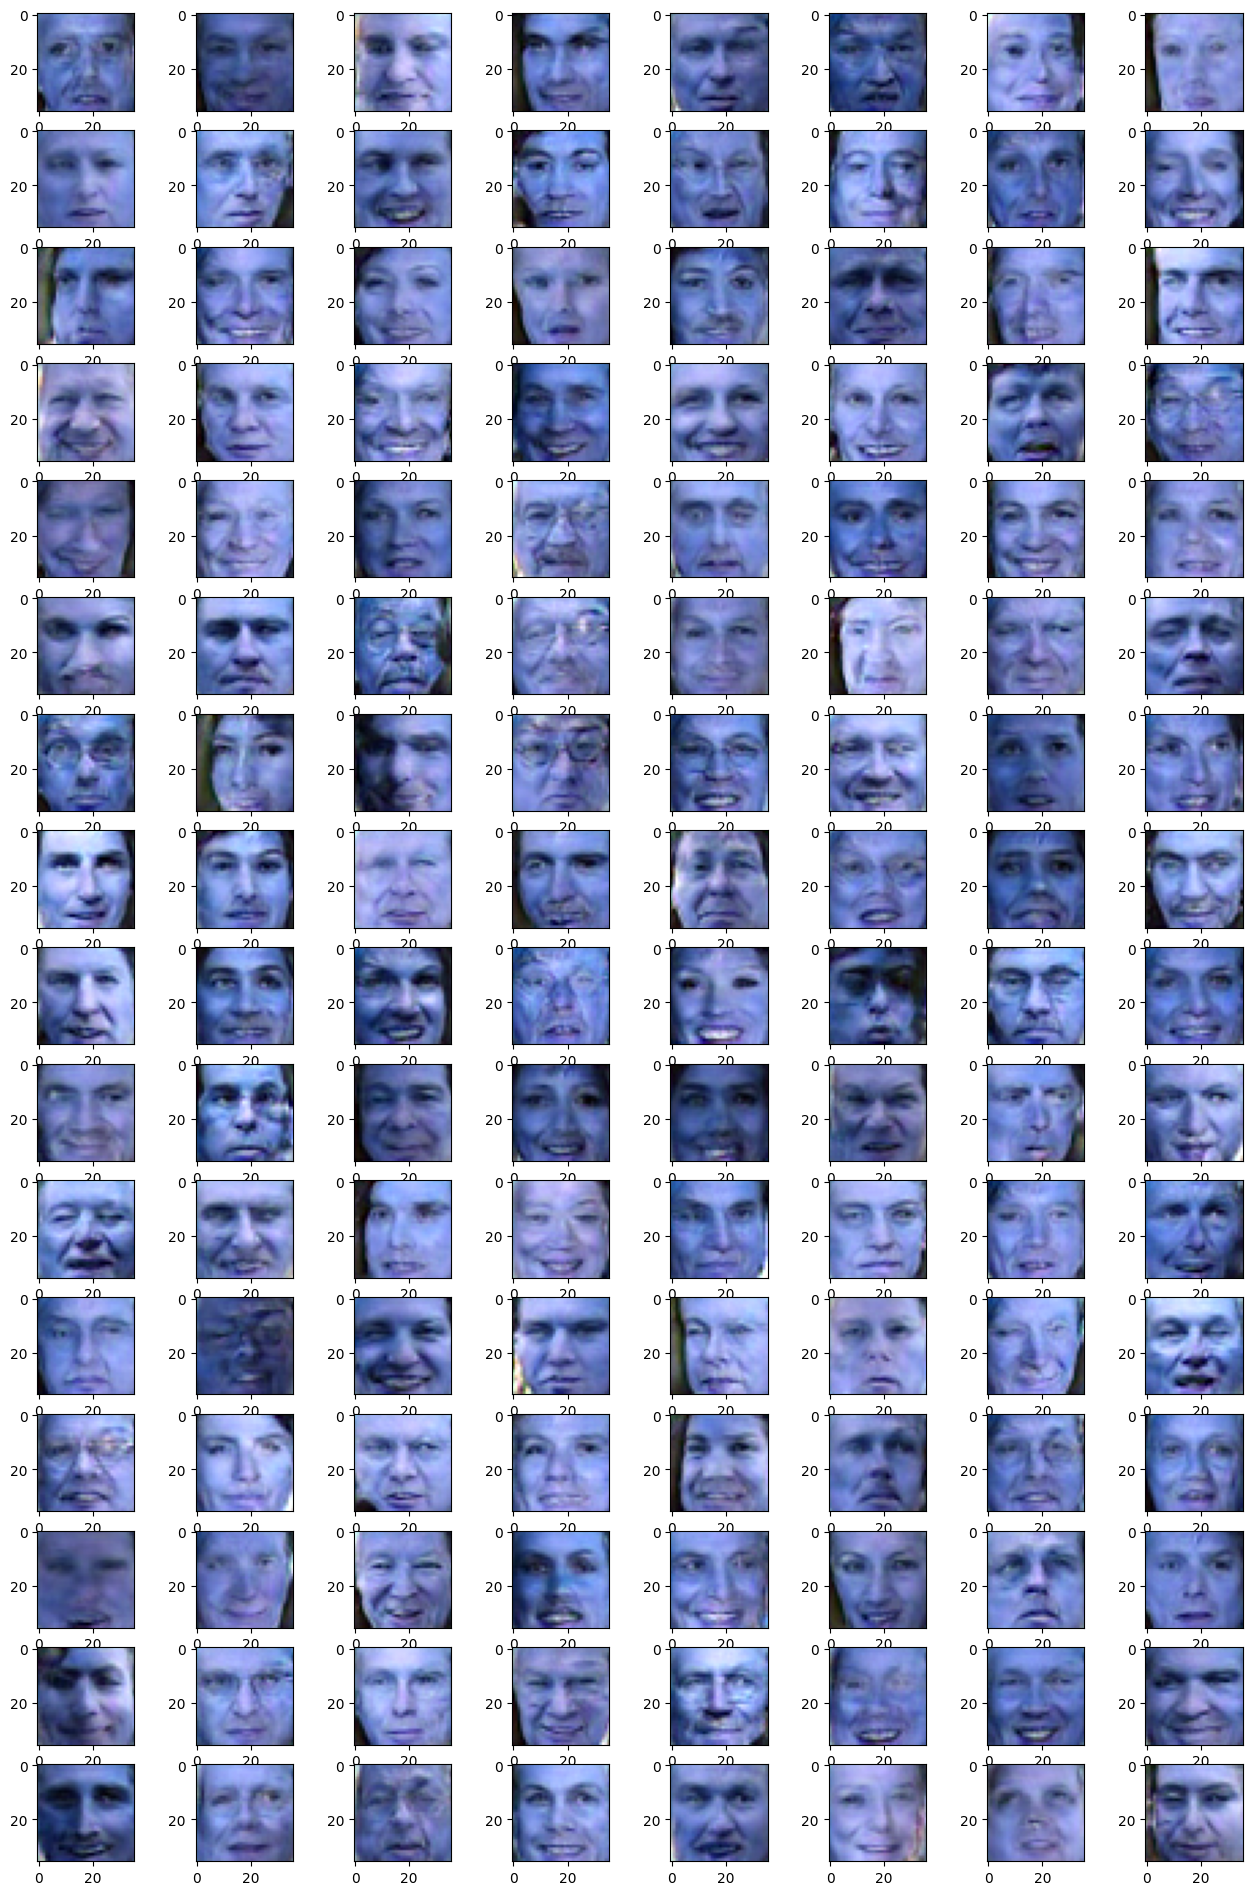

In [ ]:
# The results below are generated on the model trained for ~20k epochs
plt.figure(figsize=[16,24])
sample_images(16,8)

Some summary:

As the learning rate is higher 10 times, the convergence goes in more stochastic way in further epochs. 0.005 learning rate could be a nice speed/smoothness tradeoff for the training. The main focus for the complexity is more on the discriminator than the generator, the generator will learn anyway. Also the ratio of training loops for the discriminator and generator is important. As I've figured out, 2x ratio is an optimal solution for this case, but I think for models with higher complexity the ratio have to be higher.